In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Data Info

In [3]:
df.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### Item Categories

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


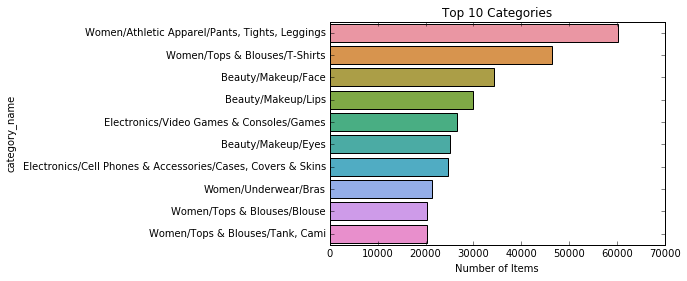

In [6]:
sns.countplot(y = df.category_name, order = df.category_name.value_counts().iloc[:10].index)
plt.title('Top 10 Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


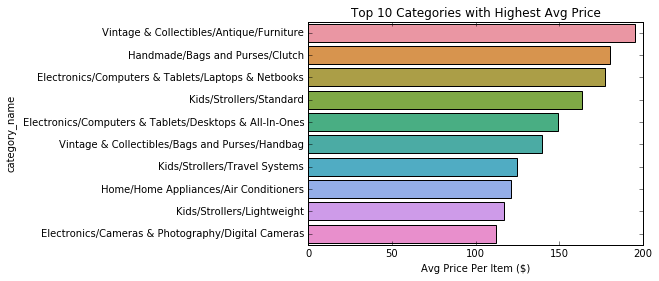

In [7]:
high_avg_price = pd.DataFrame(df.groupby('category_name')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price.index,data=high_avg_price)
plt.title('Top 10 Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


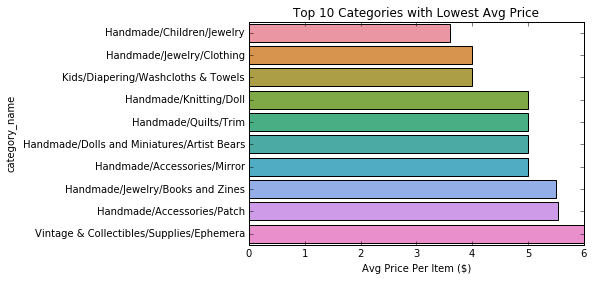

In [8]:
low_avg_price = pd.DataFrame(df.groupby('category_name')['price'].mean()).sort_values('price',ascending=1).head(10)
sns.barplot(x='price',y=low_avg_price.index,data=low_avg_price)
plt.title('Top 10 Categories with Lowest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

In [75]:
def split_cat(text):
    try: return text.split("/")
    except: return (np.nan, np.nan, np.nan)
    
df['category_1'], df['category_2'], df['category_3'] = zip(*df['category_name'].apply(lambda x: split_cat(x)))
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_1,category_2,category_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [77]:
print('category 1 unique values:',len(df.category_1.unique()))
print('category 2 unique values:',len(df.category_2.unique()))
print('category 3 unique values:',len(df.category_3.unique()))

category 1 unique values: 11
category 2 unique values: 114
category 3 unique values: 871


//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


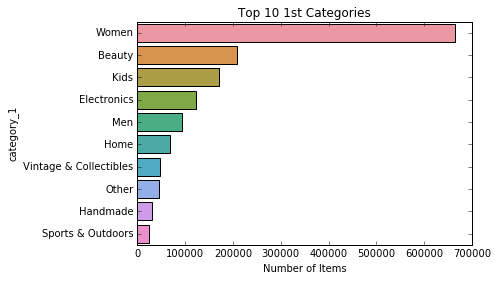

In [78]:
sns.countplot(y = df.category_1, order = df.category_1.value_counts().iloc[:10].index)
plt.title('Top 10 1st Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


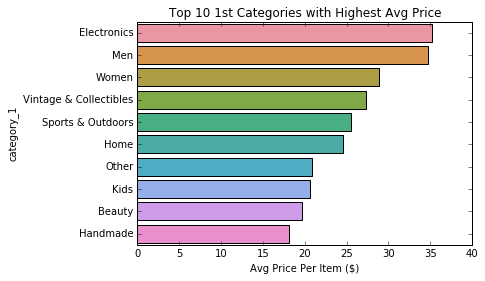

In [82]:
high_avg_price_1 = pd.DataFrame(df.groupby('category_1')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price_1.index,data=high_avg_price_1)
plt.title('Top 10 1st Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


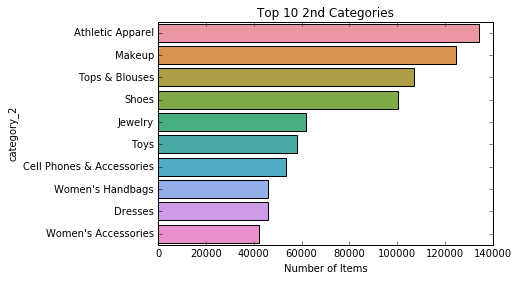

In [80]:
sns.countplot(y = df.category_2, order = df.category_2.value_counts().iloc[:10].index)
plt.title('Top 10 2nd Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


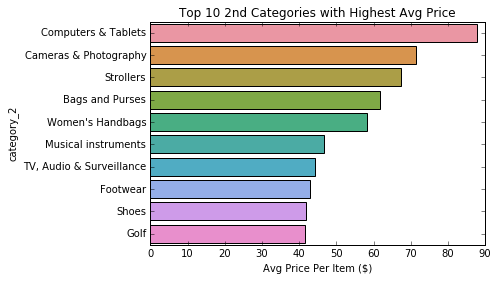

In [84]:
high_avg_price_2 = pd.DataFrame(df.groupby('category_2')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price_2.index,data=high_avg_price_2)
plt.title('Top 10 2nd Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


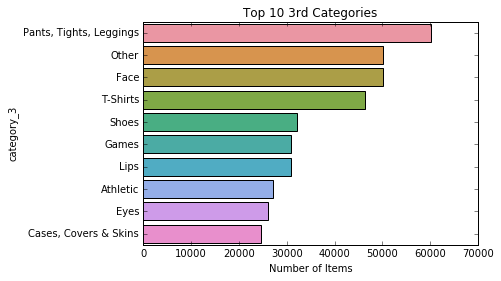

In [81]:
sns.countplot(y = df.category_3, order = df.category_3.value_counts().iloc[:10].index)
plt.title('Top 10 3rd Categories')
plt.xlabel('Number of Items')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


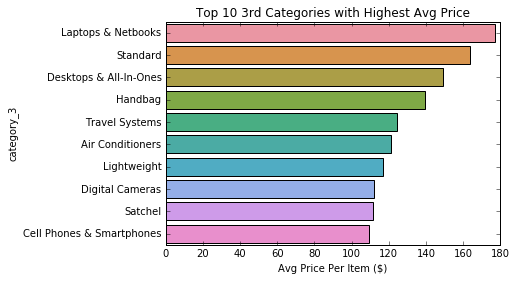

In [85]:
high_avg_price_3 = pd.DataFrame(df.groupby('category_3')['price'].mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=high_avg_price_3.index,data=high_avg_price_3)
plt.title('Top 10 3rd Categories with Highest Avg Price')
plt.xlabel('Avg Price Per Item ($)')

### Item Conditions

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


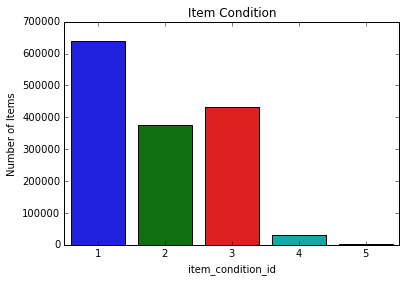

In [9]:
sns.countplot(df.item_condition_id)
plt.title('Item Condition')
plt.ylabel('Number of Items')

### Shipping

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


([<matplotlib.axis.XTick at 0x1a0d4a7ba8>,
 <a list of 2 Text xticklabel objects>)

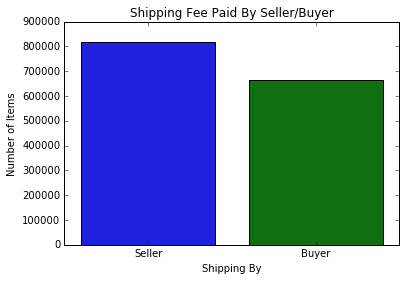

In [10]:
sns.countplot(df.shipping)
plt.title('Shipping Fee Paid By Seller/Buyer')
plt.ylabel('Number of Items')
plt.xlabel('Shipping By')
plt.xticks([0,1],['Seller','Buyer'])

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


([<matplotlib.axis.XTick at 0x1a25870dd8>,
 <a list of 2 Text xticklabel objects>)

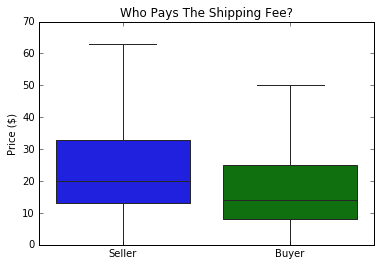

In [46]:
sns.boxplot(x=df.shipping, y = df.price, showfliers=False)
plt.title('Who Pays The Shipping Fee?')
plt.ylabel('Price ($)')
plt.xlabel('')
plt.xticks([0,1],['Seller','Buyer'])

### Price

In [11]:
df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

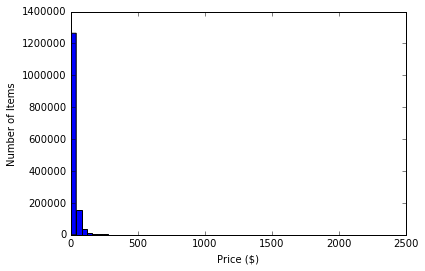

In [12]:
_ = plt.hist(df.price,bins=50)
plt.ylabel('Number of Items')
plt.xlabel('Price ($)')

In [13]:
print('99th percentile:', np.percentile(df.price,99))
print('number of $0 item:',(df.price==0).sum())

99th percentile: 170.0
number of $0 item: 874


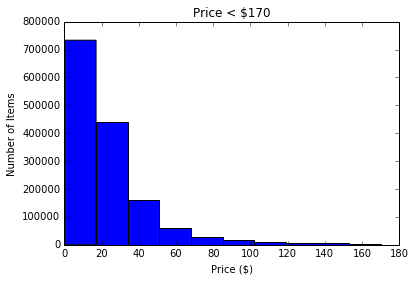

In [25]:
plt.hist(df[df.price<=170].price)
plt.ylabel('Number of Items')
plt.xlabel('Price ($)')
plt.title('Price < $170')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


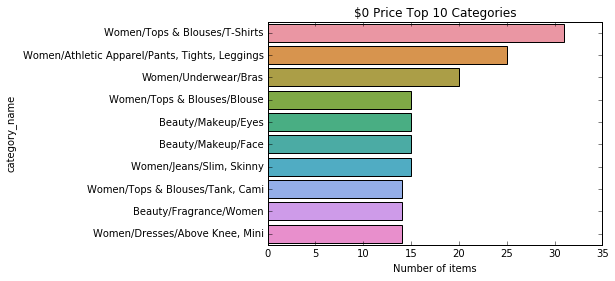

In [15]:
sns.countplot(y = df[df.price==0].category_name, order = df[df.price==0].category_name.value_counts().iloc[:10].index)
plt.title('$0 Price Top 10 Categories')
plt.xlabel('Number of items')

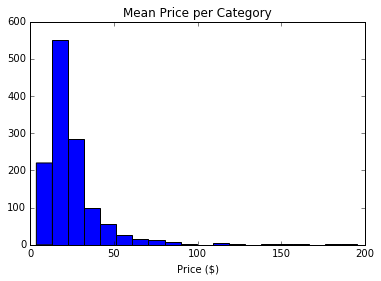

In [24]:
mean_price_category = pd.DataFrame(df.groupby('category_name').price.mean())
plt.hist(mean_price_category.price,bins=20)
plt.title('Mean Price per Category')
plt.xlabel('Price ($)')

### Item Description

count    1.482531e+06
mean     1.457118e+02
std      1.744465e+02
min      1.000000e+00
25%      4.000000e+01
50%      8.600000e+01
75%      1.740000e+02
max      1.046000e+03
Name: item_description, dtype: float64


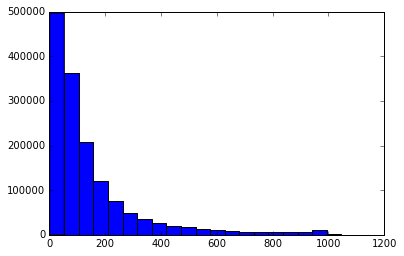

In [57]:
item_desc_length = df.item_description.str.len()
print(item_desc_length.describe())
_ = plt.hist(item_desc_length.dropna(),bins=20)

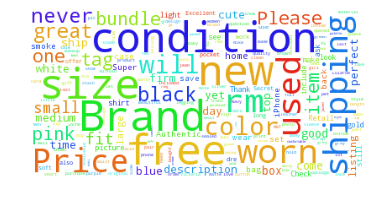

In [16]:
wc = WordCloud(background_color="white", stopwords=STOPWORDS, max_font_size= 50)
wc.generate(" ".join(str(s) for s in df.item_description.values))
plt.axis('off')
plt.imshow(wc)

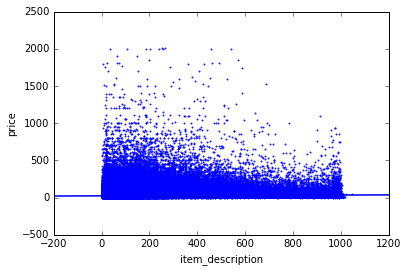

In [60]:
sns.regplot(x=item_desc_length,y='price',data=df,scatter_kws={'s':2})

In [68]:
np.corrcoef(df[['item_description','price']].dropna()['item_description'].str.len(),df[['item_description','price']].dropna()['price'])

array([[ 1.        ,  0.04804841],
       [ 0.04804841,  1.        ]])

### Brands

In [27]:
len(df.brand_name.unique())

4810

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


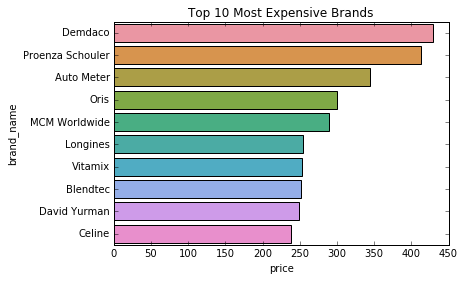

In [36]:
most_expensive_brands = pd.DataFrame(df.groupby('brand_name').price.mean()).sort_values('price',ascending=0).head(10)
sns.barplot(x='price',y=most_expensive_brands.index,data=most_expensive_brands)
plt.title('Top 10 Most Expensive Brands')

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


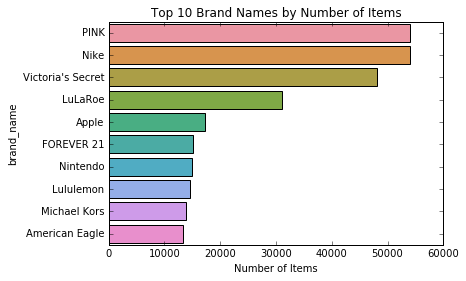

In [38]:
sns.countplot(y = df.brand_name, order = df.brand_name.value_counts().iloc[:10].index)
plt.title('Top 10 Brand Names by Number of Items')
plt.xlabel('Number of Items')